# 17 Flowers Classification

In this notebook, we classify the 17 flowers dataset. We'll use both the original dataset, and a color-constancy (CC) version that's been processed by CC methods.

First, we'll work with the original dataset.

## Imports

In [8]:
import numpy as np
import os
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt

## Preprocessing

### Load datasets

Dataset variables:

In [2]:
# list of class labels
with open("17flowers_labels.txt", "r") as f:
    flower_labels = [line.strip() for line in f]

path_to_data = "data/17flowers/"

# Split directories
train_dir = pathlib.Path(path_to_data + "train")
val_dir = pathlib.Path(path_to_data + "val")
test_dir = pathlib.Path(path_to_data + "test")

Parameters for the loader:

In [3]:
batch_size = 32
img_height = 180
img_width = 180

Create the train, val, and test datasets:

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 680 files belonging to 17 classes.
Found 340 files belonging to 17 classes.
Found 340 files belonging to 17 classes.


Verify class names are correct:

In [5]:
class_names = train_ds.class_names

assert sorted(class_names) == sorted(flower_labels)

### Visualize the data

Here are the first 9 images from the training dataset.

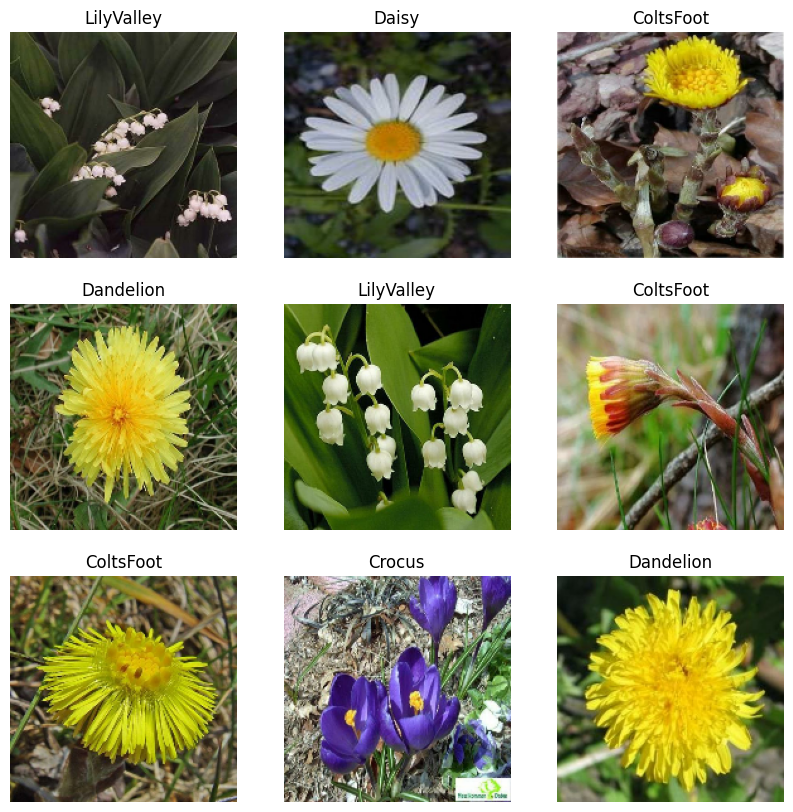

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Retrieve batches of images:

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

### Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, we will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:



In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

We can either apply this layer to the dataset, or include it as part of the model definition. We'll go with the latter.

### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Training and evaluation

We'll create a simple CNN to classify the flowers. Before setting up the architecture, let's define some useful utilities.

### Callbacks

Reduce learning rate on plateau:

In [14]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

Early stopping when loss stops decreasing:

In [15]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

### Data augmentation

Since the dataset is small, we'll use data augmentation to improve training: flip, translation, rotation, and zoom.

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
  tf.keras.layers.RandomTranslation(0.2, 0.2),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

Let's check some of the augmented images:

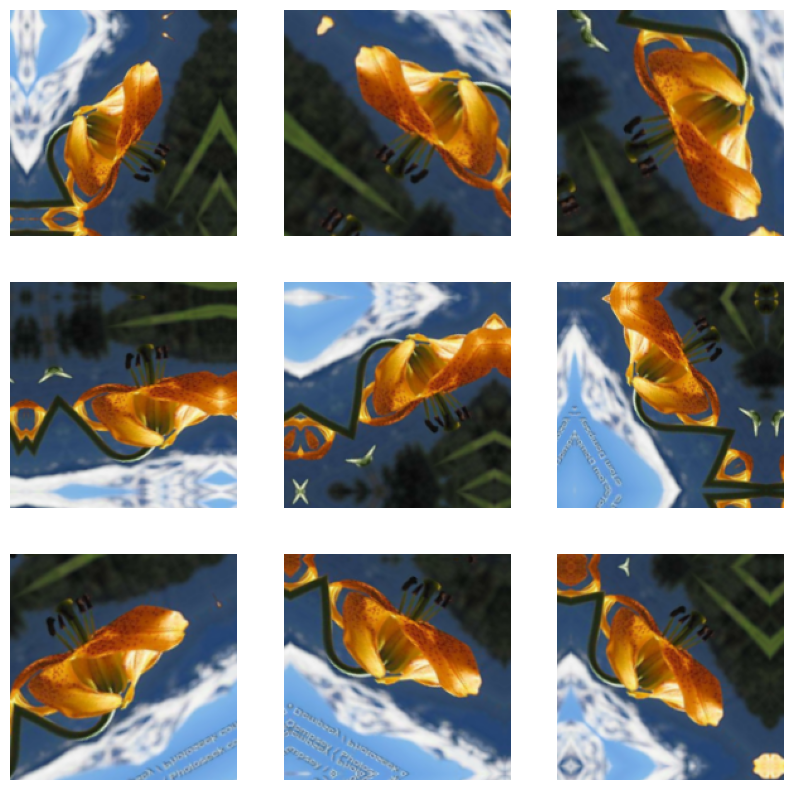

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Creating the model

Here we create the base model for classifying the flowers and to be used as reference in our experiments.

In [18]:
num_classes = 17
n_epochs = 300

def get_model():
  model = tf.keras.Sequential([
    normalization_layer,
    data_augmentation,
    tf.keras.layers.Conv2D(32, 5, activation='relu', padding="same", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
  ])
  return model

model = get_model()

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

Now we fit the model:

In [19]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop],
  verbose=0
)

And evaluate the model:

In [ ]:
score = model.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {score[1]:.3f}')

11/11 [==============================] - 0s 8ms/step - loss: 0.8825 - accuracy: 0.7235
Test accuracy: 0.724


### Batch normalization

We'll also experiment on the use of batch normalization in comparison to applying color constancy. Let's define a model that includes the batch normalization layer.

In [22]:
def get_model_batchnorm():
  model = tf.keras.Sequential([
    normalization_layer,
    data_augmentation,
    tf.keras.layers.Conv2D(32, 5, padding="same", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
  ])
  return model

model_batchnorm = get_model_batchnorm()

model_batchnorm.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

Fit the model:

In [264]:
model_batchnorm.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop],
  verbose=0
)

And evaluate the model:

In [265]:
score = model_batchnorm.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {score[1]:.3f}')

11/11 [==============================] - 0s 9ms/step - loss: 0.8066 - accuracy: 0.7412
Test accuracy: 0.741


# 17 Flowers with Color Constancy (CC)

Now, we'll apply the same pipeline to the dataset after its been processed by color constancy models. There are two methods for this:
- use implemented CC models as Keras layers;
- use the CC'ed dataset, i.e. the 17 flowers dataset preprocessed by a CC model.

In the first case, we just add the layer to our model and fit it to the original dataset. In the second, we need to create new dataset variables using the new image files from the CC'ed dataset.

## CC as Keras layers - Grey World, White Patch, and Grey Edge

Let's start with the Keras layers.

In [21]:
from processing.grey_world.cc_layers import GreyWorld, WhitePatch, GreyEdge

grey_world_layer = GreyWorld()
white_patch_layer = WhitePatch()
grey_edge_layer = GreyEdge()

def get_cc_model(cc_layer):
  model = tf.keras.Sequential([
    normalization_layer,
    cc_layer,
    data_augmentation,
    tf.keras.layers.Conv2D(32, 5, activation='relu', padding="same", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
  ])
  return model

d:\Projects\UJM\DL_CC_Classification\.venv\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Grey World:

In [49]:
cc_model_gw = get_cc_model(grey_world_layer)

cc_model_gw.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

cc_model_gw.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop], 
  verbose=0)

score_cc_gw = cc_model_gw.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {score_cc_gw[1]:.3f}')

Epoch 1/300
22/22 [==============================] - 4s 37ms/step - loss: 2.7913 - accuracy: 0.0618 - val_loss: 2.6043 - val_accuracy: 0.1088 - lr: 0.0010
Epoch 2/300
22/22 [==============================] - 1s 25ms/step - loss: 2.6217 - accuracy: 0.1191 - val_loss: 2.4079 - val_accuracy: 0.1147 - lr: 0.0010
Epoch 3/300
22/22 [==============================] - 1s 23ms/step - loss: 2.4476 - accuracy: 0.1324 - val_loss: 2.3336 - val_accuracy: 0.1735 - lr: 0.0010
Epoch 4/300
22/22 [==============================] - 1s 25ms/step - loss: 2.4028 - accuracy: 0.1456 - val_loss: 2.2008 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 5/300
22/22 [==============================] - 1s 24ms/step - loss: 2.3613 - accuracy: 0.1691 - val_loss: 2.1472 - val_accuracy: 0.2206 - lr: 0.0010
Epoch 6/300
22/22 [==============================] - 1s 24ms/step - loss: 2.2569 - accuracy: 0.2015 - val_loss: 2.0461 - val_accuracy: 0.2853 - lr: 0.0010
Epoch 7/300
22/22 [==============================] - 1s 24ms/step - lo

White Patch:

In [50]:
cc_model_wp = get_cc_model(white_patch_layer)

cc_model_wp.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

cc_model_wp.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop],
  verbose=0)

score_cc_wp = cc_model_wp.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {score_cc_wp[1]:.3f}')

Epoch 1/300
22/22 [==============================] - 4s 37ms/step - loss: 2.8403 - accuracy: 0.0588 - val_loss: 2.8265 - val_accuracy: 0.0471 - lr: 0.0010
Epoch 2/300
22/22 [==============================] - 1s 27ms/step - loss: 2.8056 - accuracy: 0.0544 - val_loss: 2.7512 - val_accuracy: 0.1176 - lr: 0.0010
Epoch 3/300
22/22 [==============================] - 1s 27ms/step - loss: 2.6163 - accuracy: 0.0956 - val_loss: 2.3968 - val_accuracy: 0.1588 - lr: 0.0010
Epoch 4/300
22/22 [==============================] - 1s 26ms/step - loss: 2.4646 - accuracy: 0.1015 - val_loss: 2.3440 - val_accuracy: 0.1765 - lr: 0.0010
Epoch 5/300
22/22 [==============================] - 1s 26ms/step - loss: 2.4155 - accuracy: 0.1294 - val_loss: 2.2519 - val_accuracy: 0.2265 - lr: 0.0010
Epoch 6/300
22/22 [==============================] - 1s 27ms/step - loss: 2.4007 - accuracy: 0.1500 - val_loss: 2.1296 - val_accuracy: 0.2176 - lr: 0.0010
Epoch 7/300
22/22 [==============================] - 1s 26ms/step - lo

Grey Edge:

In [51]:
cc_model_ge = get_cc_model(grey_edge_layer)

cc_model_ge.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

cc_model_ge.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop], 
  verbose=0)

score_cc_ge = cc_model_ge.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {score_cc_ge[1]:.3f}')

Epoch 1/300
22/22 [==============================] - 4s 45ms/step - loss: 2.8263 - accuracy: 0.0485 - val_loss: 2.8001 - val_accuracy: 0.0912 - lr: 0.0010
Epoch 2/300
22/22 [==============================] - 1s 30ms/step - loss: 2.7602 - accuracy: 0.0765 - val_loss: 2.6272 - val_accuracy: 0.1265 - lr: 0.0010
Epoch 3/300
22/22 [==============================] - 1s 31ms/step - loss: 2.6269 - accuracy: 0.1088 - val_loss: 2.4690 - val_accuracy: 0.1676 - lr: 0.0010
Epoch 4/300
22/22 [==============================] - 1s 29ms/step - loss: 2.6534 - accuracy: 0.1044 - val_loss: 2.4691 - val_accuracy: 0.1559 - lr: 0.0010
Epoch 5/300
22/22 [==============================] - 1s 30ms/step - loss: 2.4986 - accuracy: 0.1529 - val_loss: 2.3210 - val_accuracy: 0.1912 - lr: 0.0010
Epoch 6/300
22/22 [==============================] - 1s 30ms/step - loss: 2.5331 - accuracy: 0.1353 - val_loss: 2.3163 - val_accuracy: 0.1676 - lr: 0.0010
Epoch 7/300
22/22 [==============================] - 1s 30ms/step - lo

## CC'ed Dataset - FC4

Now we'll use the CC'ed Dataset preprocessed by the FC4 CC model.

In [25]:
path_to_data_cc = "data/17flowers/cc/"

train_dir_cc = pathlib.Path(path_to_data_cc + "train")
val_dir_cc = pathlib.Path(path_to_data_cc + "val")
test_dir_cc = pathlib.Path(path_to_data_cc + "test")

train_ds_cc = tf.keras.utils.image_dataset_from_directory(
  train_dir_cc,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds_cc = tf.keras.utils.image_dataset_from_directory(
  val_dir_cc,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

test_ds_cc = tf.keras.utils.image_dataset_from_directory(
  test_dir_cc,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 680 files belonging to 17 classes.
Found 340 files belonging to 17 classes.
Found 340 files belonging to 17 classes.


This is what the dataset looks like:

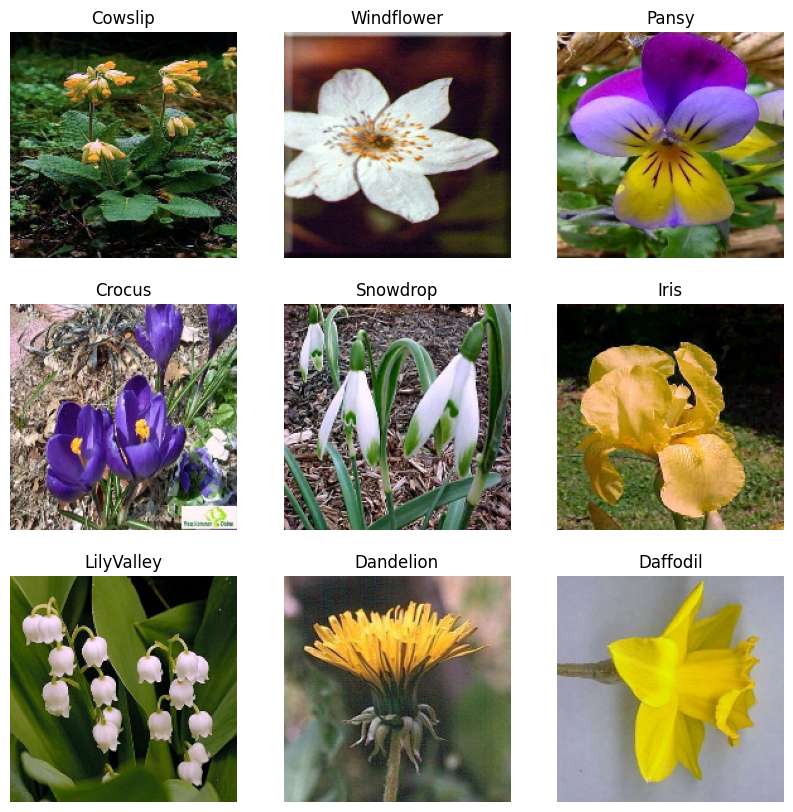

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds_cc.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Finally, optimize the dataset for performance:

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_cc = train_ds_cc.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_cc = val_ds_cc.cache().prefetch(buffer_size=AUTOTUNE)
test_ds_cc = test_ds_cc.cache().prefetch(buffer_size=AUTOTUNE)

Now we fit the model to the CC'ed dataset:

In [56]:
model_cc_fc4 = get_model()

model_cc_fc4.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

model_cc_fc4.fit(
  train_ds_cc,
  validation_data=val_ds_cc,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop], 
  verbose=0)

score_cc_fc4 = model_cc_fc4.evaluate(test_ds_cc, verbose=0)
print(f'Test accuracy: {score_cc_fc4[1]:.3f}')

Epoch 1/300


2023-05-07 18:12:42.424616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [680]
	 [[{{node Placeholder/_4}}]]
2023-05-07 18:12:42.424917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [680]
	 [[{{node Placeholder/_0}}]]


19/22 [========================>.....] - ETA: 0s - loss: 2.8094 - accuracy: 0.0559

2023-05-07 18:12:45.511817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [340]
	 [[{{node Placeholder/_0}}]]
2023-05-07 18:12:45.512133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [340]
	 [[{{node Placeholder/_0}}]]


22/22 [==============================] - 3s 36ms/step - loss: 2.7908 - accuracy: 0.0529 - val_loss: 2.7253 - val_accuracy: 0.0882 - lr: 0.0010
Epoch 2/300
22/22 [==============================] - 0s 23ms/step - loss: 2.5860 - accuracy: 0.1279 - val_loss: 2.4126 - val_accuracy: 0.1206 - lr: 0.0010
Epoch 3/300
22/22 [==============================] - 0s 23ms/step - loss: 2.4284 - accuracy: 0.1353 - val_loss: 2.2942 - val_accuracy: 0.1647 - lr: 0.0010
Epoch 4/300
22/22 [==============================] - 0s 23ms/step - loss: 2.4004 - accuracy: 0.1397 - val_loss: 2.2191 - val_accuracy: 0.2206 - lr: 0.0010
Epoch 5/300
22/22 [==============================] - 0s 22ms/step - loss: 2.2856 - accuracy: 0.1662 - val_loss: 2.0696 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 6/300
22/22 [==============================] - 0s 22ms/step - loss: 2.2699 - accuracy: 0.1809 - val_loss: 2.0787 - val_accuracy: 0.2588 - lr: 0.0010
Epoch 7/300
22/22 [==============================] - 1s 23ms/step - loss: 2.1367 -

2023-05-07 18:13:58.773815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [340]
	 [[{{node Placeholder/_0}}]]
2023-05-07 18:13:58.774195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [340]
	 [[{{node Placeholder/_0}}]]


11/11 [==============================] - 0s 9ms/step - loss: 0.9501 - accuracy: 0.7529
Test accuracy: 0.753


# Experiment

For the evaluation experiment, we'll run 10 trials of training/evaluation for each model. The collected data will be:
- time, accuracy, and loss for train, validation, and test;
- number of epochs

We'll compare all results with the base model.

In [28]:
import time

def experiment(model, train_ds, val_ds, test_ds, n_trials=10):
    metrics = {
        "train_time": [],
        "test_time": [],
        "train_acc": [],
        "train_loss": [],
        "val_acc": [],
        "val_loss": [],
        "test_acc": [],
        "test_loss": [],
        "history": []
    }

    for i in range(n_trials):        
        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

        start_time = time.perf_counter()
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=n_epochs,
            callbacks=[reduce_lr, early_stop],
            verbose=0)
        end_time = time.perf_counter()
        training_time = end_time - start_time

        start_time = time.perf_counter()
        test_loss, test_acc = model.evaluate(test_ds, verbose=0)
        end_time = time.perf_counter()
        test_time = end_time - start_time

        metrics["train_time"].append(training_time)
        metrics["test_time"].append(test_time)
        metrics["train_acc"].append(history.history["accuracy"][-1])
        metrics["train_loss"].append(history.history["loss"][-1])
        metrics["val_acc"].append(history.history["val_accuracy"][-1])
        metrics["val_loss"].append(history.history["val_loss"][-1])
        metrics["test_acc"].append(test_acc)
        metrics["test_loss"].append(test_loss)
        metrics["history"].append(history)
    return metrics

In [31]:
# Create new models
model_base = get_model()
model_batch = get_model_batchnorm()
model_gw = get_cc_model(grey_world_layer)
model_ge = get_cc_model(grey_edge_layer)
model_wp = get_cc_model(white_patch_layer)
model_fc4 = get_model()

# Run experiments
n_trials = 1
metrics = {}
metrics["Base"] = experiment(model_base, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics["BatchNorm"] = experiment(model_batch, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics["GreyWorld"] = experiment(model_gw, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics["GreyEdge"] = experiment(model_ge, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics["WhitePatch"] = experiment(model_wp, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics["FC4"] = experiment(model_fc4, train_ds_cc, val_ds_cc, test_ds_cc, n_trials=n_trials)

KeyboardInterrupt: 

In [ ]:
import pandas as pd
from datetime import datetime

# Get the current timestamp
timestamp = datetime.now()

# Convert the timestamp to a string format
timestamp_str = timestamp.strftime("%Y-%m-%d %H-%M-%S")

with pd.ExcelWriter("./out/{timestamp_str}_experiments_17flowers.xlsx", engine='xlsxwriter',) as writer:    
    end_data = pd.concat({k: pd.DataFrame(v) for k, v in metrics.items()}, axis=0, names=["Algorithm", "Trial"])
    end_data.drop("history", axis=1, inplace=True)
    print(end_data)

    end_data.to_excel(writer, "Final Data")

    for k, metric in metrics.items():
        histories = metric["history"]
        algo_data = pd.concat({f"{i}": pd.DataFrame(history.history) for i, history in enumerate(histories)}, axis=1)
        print(algo_data)
        algo_data.to_excel(writer, f"{k} History")

Now let's visualize the results.

In [318]:
def calc_y_limits(y, margin=0.15):
    """
        Return min and max values for the provided y values according to given margin.
        To be used with matplotlib `set_ylim()`.
    """
    y_min = np.min(y)
    y_max = np.max(y)
    y_range = y_max - y_min
    y_margin = margin * y_range
    y_min_limit = y_min - y_margin
    y_max_limit = y_max + y_margin
    return y_min_limit, y_max_limit


def add_history_avg(all_metrics, n_trials):
    """
        Add "history_avg" key to all provided metrics, which contains the average values
        for all the `history` objects inside the metric.

        Basically calculates averages of the training history so that they can be plotted.
    """
    for m in all_metrics:
        m["history_avg"] = {
        "accuracy": [],
        "loss": [],
        "val_accuracy": [],
        "val_loss": []
        }
        for kpi in m["history_avg"].keys():
            n_epochs = []
            for trial in range(n_trials):
                # Check all trials to find the one with most epochs. We'll calculate averages until the last epoch.
                n_epochs.append(len(m["history"][trial].history[kpi]))
            for epoch in range(max(n_epochs)):
                epoch_values = []
                epoch_count = 0
                for trial in range(n_trials):
                    try:
                        epoch_values.append(m["history"][trial].history[kpi][epoch])
                        epoch_count += 1
                    except IndexError:
                        # We skip counting when a trial has less epochs than the current epoch.
                        # Doing this causes abrupt changes to show up along the plot.
                        pass
                epoch_avg = sum(epoch_values)/epoch_count
                m["history_avg"][kpi].append(epoch_avg)

# Tensorboard

We can use Tensorboard to visualize training data for a model.

In [322]:
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

def run_with_tensorboard(model, train_ds, val_ds):
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])

    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=n_epochs,
        callbacks=[reduce_lr, early_stop, tensorboard], 
        verbose=0)

To open Tensorboard, run the following in the terminal:

```sh
tensorboard logsdir=./logs
```

If `tensorboard` is not in `PATH`, you can use the path to the binary instead. VS Code has Tensorboard integration, so it can also be used.

In [323]:
model_tensorboard = get_model()

run_with_tensorboard(model_tensorboard, train_ds, val_ds)